<a href="https://colab.research.google.com/github/makrez/BioinformaticsTools/blob/master/Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [ ]:
import re
import os
!pip install biopython
from Bio import SeqIO
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class hot_dna:
    def __init__(self, sequence):
        sequence = sequence.upper()
        self.sequence = self._preprocess_sequence(sequence)
        self.category_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'U': 3, '-': 4, 'N': 5}
        self.onehot = self._onehot_encode(self.sequence)

    def _preprocess_sequence(self, sequence):
        ambiguous_bases = {'R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V'}
        new_sequence = ""
        for base in sequence:
            if base in ambiguous_bases:
                new_sequence += 'N'
            else:
                new_sequence += base
        return new_sequence

    def _onehot_encode(self, sequence):
        integer_encoded = np.array([self.category_mapping[char] for char in sequence]).reshape(-1, 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        # Fill missing channels with zeros
        full_onehot_encoded = np.zeros((len(sequence), 6))
        full_onehot_encoded[:, :onehot_encoded.shape[1]] = onehot_encoded
        
        return full_onehot_encoded



In [ ]:
flatted_sequence = list()
sequence_labels = list()

alignment_length = 1500

with open('/content/drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
  for record in SeqIO.parse(handle, 'fasta'):
    label = str(record.description).rsplit(';', 1)[-1]
    seq_hot = hot_dna(str(record.seq)[10:alignment_length+10]).onehot
    
    if len(seq_hot) == alignment_length:
      flatted_sequence.append(seq_hot)
      sequence_labels.append(label)

In [ ]:
from Bio import AlignIO
from collections import Counter

def summarize_msa(file_path, num_lines_to_display=5):
    alignment = AlignIO.read(file_path, 'fasta')
    num_sequences = len(alignment)
    alignment_length = alignment.get_alignment_length()

    # Count occurrences of each base and gaps
    counts = Counter()
    total_bases = num_sequences * alignment_length
    for record in alignment:
        counts.update(record.seq)
        
    # Calculate the percentages
    percentages = {base: (count / total_bases) * 100 for base, count in counts.items()}

    print(f"Number of sequences: {num_sequences}")
    print(f"Alignment length: {alignment_length}")
    print("\nPercentages of bases and gaps:")
    for base, percentage in percentages.items():
        if percentage > 0:
            print(f"{base}: {percentage:.2f}%")
    
    print("\nFirst few lines of the alignment:")
    for idx, record in enumerate(alignment):
        if idx < num_lines_to_display:
            print(f"{record.id}: {record.seq}")
        else:
            break

# Read and summarize the MSA
msa_file_path = '/content/drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln'
summarize_msa(msa_file_path)



Number of sequences: 2626
Alignment length: 4559

Percentages of bases and gaps:
-: 35.89%
c: 14.05%
g: 19.88%
u: 12.92%
a: 17.25%
y: 0.00%
n: 0.00%
r: 0.00%
v: 0.00%
w: 0.00%
m: 0.00%
s: 0.00%
k: 0.00%

First few lines of the alignment:
CP013727.2895443.2898376: ---------------------------cgguuaaguua-ga-aagggcg--cacgguggaug-ccuuggca-cuaggagccg--aug-a-----aggacggg-acgaacac-cgauaug-c-uuc-ggggagcuguaagcaagc-uuugaucc--ggag-auuuccgaau-ggggaaacccacca-cucguaauggagu---gguauccau--a-ucugaaua--cauaggauaugagaaggcagaccc-ggggaacug-aaacaucu-aagu-accc-gg-aggaagag-aaagcaaaugcga---uucccu-gaguag-cggcgag--cg-aaacggga-ccagcccaaa-ccaagagg---cuugccucuu-ggg-g-uuguagg-acacucu-guacggag-uuacaa-aggaacg-aggua---gaugaagaggucuggaaa-ggcccgccauag---gaggu-aacag-cccugua-gucaaaac----uucgu--ucu---cuccugagugg-auccuga-------------------------------------------------------------------------------------------------------------------------------guacggcgga------acacgug--aaauuccguc-ggaauc-cgggaggacc-aucucc-caaggc-uaaau----acucc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConvAutoencoder(nn.Module):
    def __init__(self, input_length):
        super(ConvAutoencoder, self).__init__()
        self.input_length = input_length
        
        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )

        # Decoding layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(16, 6, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Calculate padding sizes
        encoder_padding = (input_length - 1) % 2
        decoder_padding = (input_length % 2) * 2

        # Initialize padding layers
        self.pad_encoder = nn.ConstantPad1d((encoder_padding, 0), 0)
        self.pad_decoder = nn.ConstantPad1d((0, decoder_padding), 0)

        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        # Encoding layers
        x = self.pad_encoder(x)
        x = self.encoder(x)

        # Decoding layers
        x = self.decoder(x)
        x = self.pad_decoder(x)

        return x



# Instantiate the model
model = ConvAutoencoder(input_length = alignment_length)
print(model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(8, 16, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(16, 6, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (3): Sigmoid()
  )
  (pad_encoder): ConstantPad1d(padding=(1, 0), value=0)
  (pad_decoder): ConstantPad1d(padding=(0, 0), value=0)
)


## Loading DNA data and transforming it to one-hot encoded data



In [ ]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __getitem__(self, index):
        return torch.tensor(self.sequences[index]).float()
    
    def __len__(self):
        return len(self.sequences)


In [ ]:
from torch.utils.data import DataLoader

# Create dataset
dataset = SequenceDataset(flatted_sequence)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
dataset = SequenceDataset(flatted_sequence)
print("Length of dataset:", len(dataset))

sample = dataset[0]
print("Shape of sample:", sample.shape)
#print(dataset[0])
print(model)

Length of dataset: 2626
Shape of sample: torch.Size([1500, 6])
ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(8, 16, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(16, 6, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (3): Sigmoid()
  )
  (pad_encoder): ConstantPad1d(padding=(1, 0), value=0)
  (pad_decoder): ConstantPad1d(padding=(0, 0), value=0)
)


In [ ]:
import matplotlib.pyplot as plt

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
n_epochs = 50

# Define the batch size
batch_size = 32

# Define the dataloader
dataset = SequenceDataset(flatted_sequence)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
train_losses = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for batch_idx, data in enumerate(dataloader):
        # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
        data = data.permute(0, 2, 1)
        data = data.float().to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        
        # Compute the loss
        loss = criterion(outputs, data)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss
        train_loss += loss.item() * data.size(0)
    
    # Print the average training loss for the epoch
    train_loss /= len(dataloader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # Append the training loss to the list
    train_losses.append(train_loss)
    





Epoch: 1 	Training Loss: 0.106906
Epoch: 2 	Training Loss: 0.086790
Epoch: 3 	Training Loss: 0.070194
Epoch: 4 	Training Loss: 0.059581
Epoch: 5 	Training Loss: 0.052304
Epoch: 6 	Training Loss: 0.046490
Epoch: 7 	Training Loss: 0.041324
Epoch: 8 	Training Loss: 0.037286
Epoch: 9 	Training Loss: 0.034092
Epoch: 10 	Training Loss: 0.031430
Epoch: 11 	Training Loss: 0.029150
Epoch: 12 	Training Loss: 0.027389
Epoch: 13 	Training Loss: 0.025851
Epoch: 14 	Training Loss: 0.024431
Epoch: 15 	Training Loss: 0.023208
Epoch: 16 	Training Loss: 0.022212
Epoch: 17 	Training Loss: 0.021430
Epoch: 18 	Training Loss: 0.020805
Epoch: 19 	Training Loss: 0.020298
Epoch: 20 	Training Loss: 0.019892
Epoch: 21 	Training Loss: 0.019520
Epoch: 22 	Training Loss: 0.019258
Epoch: 23 	Training Loss: 0.019052
Epoch: 24 	Training Loss: 0.018877
Epoch: 25 	Training Loss: 0.018754
Epoch: 26 	Training Loss: 0.018661
Epoch: 27 	Training Loss: 0.018587
Epoch: 28 	Training Loss: 0.018524
Epoch: 29 	Training Loss: 0.0

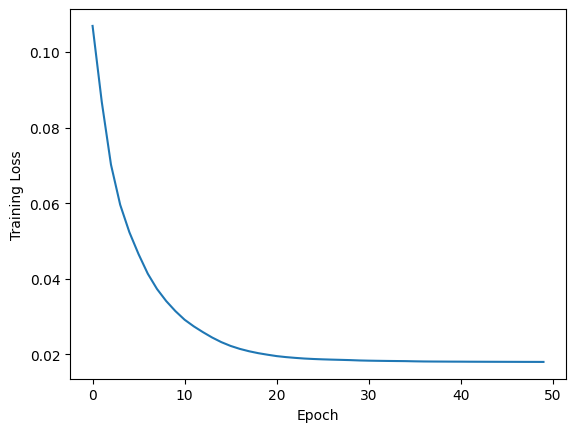

In [ ]:
# Plot the loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create a list to store the latent vectors
latent_vectors = []
labels = []

# Iterate over the sequences in the dataset and obtain their latent vectors
for sequence, label in zip(flatted_sequence, sequence_labels):
    # Transform the sequence tensor to have the shape (1, n_channels, sequence_length)
    sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
    sequence = sequence.float().to(device)

    # Obtain the latent vector
    latent_vector = model.encoder(sequence).detach().cpu().numpy()

    # Add the latent vector to the list
    latent_vectors.append(latent_vector)
    labels.append(label)


  
print(len(latent_vectors[0][0][0]))
print(len(latent_vectors[0][0]))
print(len(latent_vectors[0]))
print(len(latent_vectors))
!pip install umap-learn
import umap.umap_ as umap

# Convert the list of latent vectors to a 2D numpy array
latent_vectors_array = np.array(latent_vectors)
print(latent_vectors_array.shape)
latent_vectors_array_reshaped = latent_vectors_array.reshape(len(latent_vectors), -1)
print(latent_vectors_array_reshaped.shape)

# Fit the UMAP model to the latent vectors
umap_model = umap.UMAP(n_neighbors=100, min_dist=0.1, random_state=42)
umap_embedding = umap_model.fit_transform(latent_vectors_array_reshaped)






375
8
1
2626
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(2626, 1, 8, 375)
(2626, 3000)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


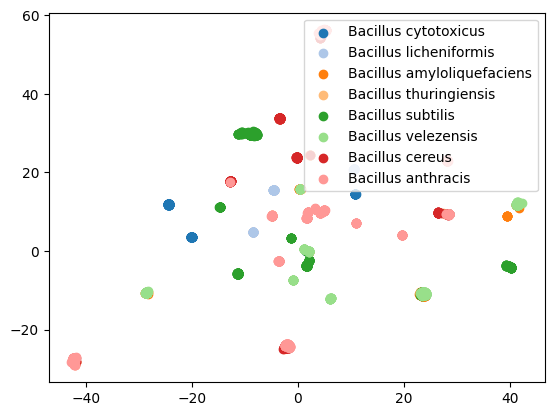

In [ ]:
# Create a scatter plot for each unique label
unique_labels = set(labels)
color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots()
for label in unique_labels:
    # Get the indices of the data points with this label
    indices = [i for i, x in enumerate(labels) if x == label]
    
    # Get the corresponding UMAP coordinates and colors
    coords = umap_embedding[indices]
    color = color_dict[label]
    
    # Add the scatter plot for this label to the axes
    ax.scatter(coords[:, 0], coords[:, 1], color=color, label=label)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

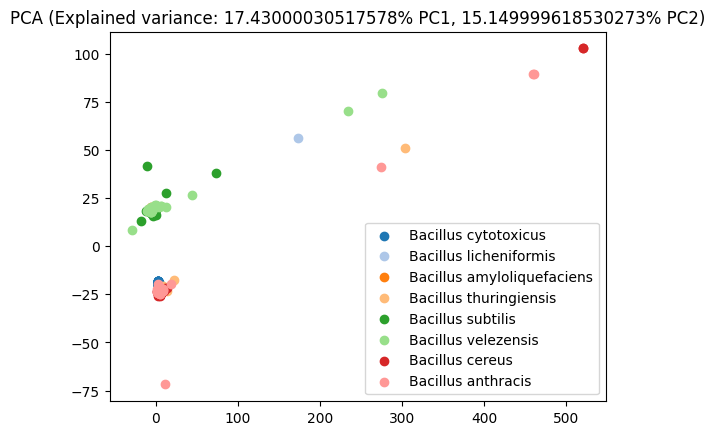

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
latent_vectors_standardized = scaler.fit_transform(latent_vectors_array_reshaped)

# Apply PCA
pca_model = PCA(n_components=2)
pca_embedding = pca_model.fit_transform(latent_vectors_standardized)

# Calculate the explained variance ratios
explained_variance = pca_model.explained_variance_ratio_
explained_variance_percentage = np.round(explained_variance * 100, decimals=2)

# Create a scatter plot for each unique label
unique_labels = set(labels)
color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots()
for label in unique_labels:
    # Get the indices of the data points with this label
    indices = [i for i, x in enumerate(labels) if x == label]
    
    # Get the corresponding PCA coordinates and colors
    coords = pca_embedding[indices]
    color = color_dict[label]
    
    # Add the scatter plot for this label to the axes
    ax.scatter(coords[:, 0], coords[:, 1], color=color, label=label)

# Add a legend to the plot
ax.legend()

# Add the explained variance percentage to the plot
ax.set_title(f"PCA (Explained variance: {explained_variance_percentage[0]}% PC1, {explained_variance_percentage[1]}% PC2)")

# Show the plot
plt.show()



              0            1            2            3            4     \
count  2626.000000  2626.000000  2626.000000  2626.000000  2626.000000   
mean      0.844469     2.019748     2.018233     4.754382    10.480718   
std       0.000983     0.101305     0.023659     2.032499     3.759074   
min       0.844450     2.017771     2.017771     2.017771     2.017771   
25%       0.844450     2.017771     2.017771     2.017771     7.692047   
50%       0.844450     2.017771     2.017771     5.311323     9.304431   
75%       0.844450     2.017771     2.017771     7.386221    14.469536   
max       0.894833     7.209080     3.230170     9.777858    16.291401   

              5            6            7            8            9     ...  \
count  2626.000000  2626.000000  2626.000000  2626.000000  2626.000000  ...   
mean     12.431243     5.125784     9.218953    12.056856     0.013261  ...   
std       2.826836     0.618724     0.720769     0.613652     0.223612  ...   
min       2.01777

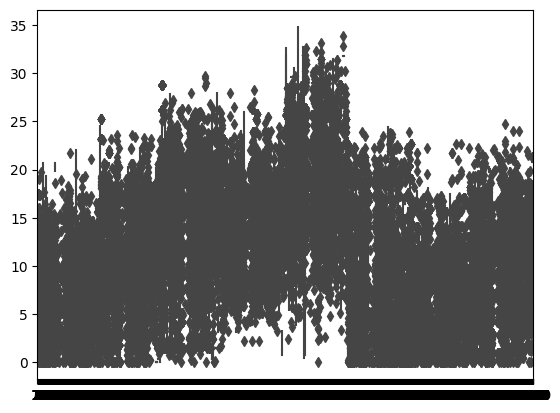

In [ ]:
import pandas as pd
import seaborn as sns

# Convert the data to a Pandas DataFrame
latent_vectors_df = pd.DataFrame(latent_vectors_array_reshaped)

# Calculate basic statistics
print(latent_vectors_df.describe())

# Create a box plot to visualize the data distribution
sns.boxplot(data=latent_vectors_df)
plt.show()


# Variational Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_length, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_length = input_length
        
        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )

        self.fc_mu = nn.Linear(8 * input_length // 4, latent_dim)
        self.fc_var = nn.Linear(8 * input_length // 4, latent_dim)

        # Decoding layers
        self.fc_dec = nn.Linear(latent_dim, 8 * input_length // 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(16, 6, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(x.size(0), 8, -1)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var


# Instantiate the model
alignment_length = 1500 # replace with the actual alignment_length value
latent_dim = 2
model = VariationalAutoencoder(input_length=alignment_length, latent_dim=latent_dim)
print(model)


VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_mu): Linear(in_features=3000, out_features=2, bias=True)
  (fc_var): Linear(in_features=3000, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=3000, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose1d(8, 16, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(16, 6, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (3): Sigmoid()
  )
)


In [ ]:
import torch.optim as optim



# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
n_epochs = 50

# Define the batch size
batch_size = 32

# Define the dataloader
dataset = SequenceDataset(flatted_sequence)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
train_losses = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for batch_idx, data in enumerate(dataloader):
        # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
        data = data.permute(0, 2, 1)
        data = data.float().to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        x_recon, mu, log_var = model(data)
        
        # Compute the loss
        loss = vae_loss(data, x_recon, mu, log_var)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss
        train_loss += loss.item() * data.size(0)
    
    # Print the average training loss for the epoch
    train_loss /= len(dataloader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # Append the training loss to the list
    train_losses.append(train_loss)


Epoch: 1 	Training Loss: 191441.132014
Epoch: 2 	Training Loss: 119957.048002
Epoch: 3 	Training Loss: 77627.212104
Epoch: 4 	Training Loss: 53166.838801
Epoch: 5 	Training Loss: 37936.456162
Epoch: 6 	Training Loss: 28148.974376
Epoch: 7 	Training Loss: 21860.074169
Epoch: 8 	Training Loss: 18053.004894
Epoch: 9 	Training Loss: 15546.228741
Epoch: 10 	Training Loss: 13701.469689
Epoch: 11 	Training Loss: 12237.424698
Epoch: 12 	Training Loss: 11134.140845
Epoch: 13 	Training Loss: 10207.041930
Epoch: 14 	Training Loss: 9523.392997
Epoch: 15 	Training Loss: 8826.722045
Epoch: 16 	Training Loss: 8283.809047
Epoch: 17 	Training Loss: 7805.007265
Epoch: 18 	Training Loss: 7308.446372
Epoch: 19 	Training Loss: 6915.736922
Epoch: 20 	Training Loss: 6469.067263
Epoch: 21 	Training Loss: 5984.798680
Epoch: 22 	Training Loss: 5608.915826
Epoch: 23 	Training Loss: 5274.617264
Epoch: 24 	Training Loss: 4925.704028
Epoch: 25 	Training Loss: 4639.478273
Epoch: 26 	Training Loss: 4445.260749
Epoch:

Plot the latent space

(2626, 2)


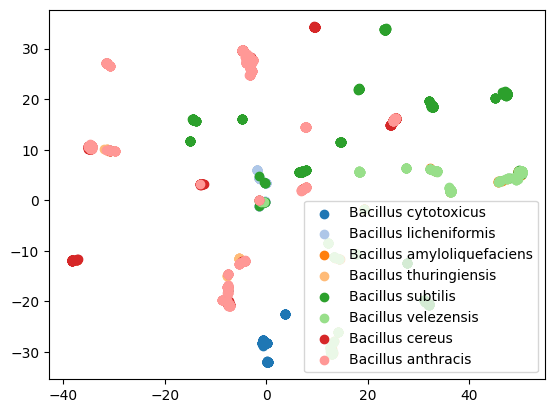

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap

# Set the model to evaluation mode
model.eval()

# Create a list to store the latent vectors
latent_vectors = []
labels = []

# Iterate over the sequences in the dataset and obtain their latent vectors
for sequence, label in zip(flatted_sequence, sequence_labels):
    # Transform the sequence tensor to have the shape (1, n_channels, sequence_length)
    sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
    sequence = sequence.float().to(device)

    # Obtain the latent vector (mu)
    mu, _ = model.encode(sequence)
    mu = mu.detach().cpu().numpy()

    # Add the latent vector to the list
    latent_vectors.append(mu)
    labels.append(label)

# Convert the list of latent vectors to a 2D numpy array
latent_vectors_array = np.array(latent_vectors).squeeze()
print(latent_vectors_array.shape)

# Fit the UMAP model to the latent vectors
umap_model = umap.UMAP(n_neighbors=100, min_dist=0.1, random_state=42)
umap_embedding = umap_model.fit_transform(latent_vectors_array)

# Create a scatter plot for each unique label
unique_labels = set(labels)
color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots()
for label in unique_labels:
    # Get the indices of the data points with this label
    indices = [i for i, x in enumerate(labels) if x == label]
    
    # Get the corresponding UMAP coordinates and colors
    coords = umap_embedding[indices]
    color = color_dict[label]
    
    # Add the scatter plot for this label to the axes
    ax.scatter(coords[:, 0], coords[:, 1], color=color, label=label)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


In [ ]:
print(mu.shape)

(1, 2)


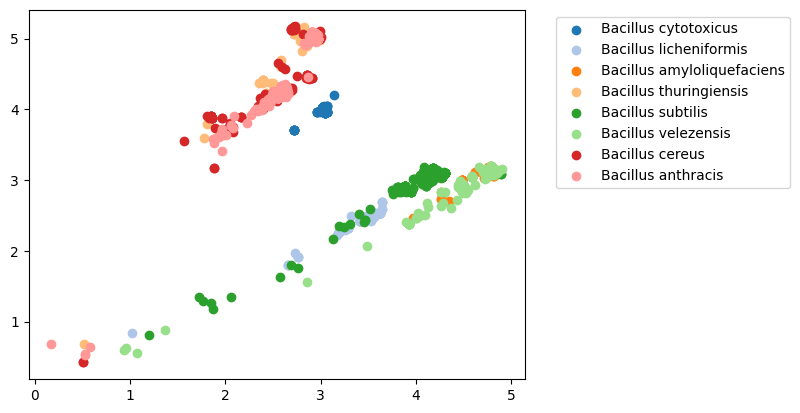

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create a list to store the latent vectors
latent_vectors = []
labels = []

# Iterate over the sequences in the dataset and obtain their latent vectors
for sequence, label in zip(flatted_sequence, sequence_labels):
    # Transform the sequence tensor to have the shape (1, n_channels, sequence_length)
    sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
    sequence = sequence.float().to(device)

    # Obtain the latent vector (mu)
    mu, _ = model.encode(sequence)
    mu = mu.detach().cpu().numpy()

    # Add the latent vector to the list
    latent_vectors.append(mu)
    labels.append(label)

# Convert the list of latent vectors to a 2D numpy array
latent_vectors_array = np.array(latent_vectors).squeeze()

# Create a scatter plot for each unique label
unique_labels = set(labels)
color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots()
for label in unique_labels:
    # Get the indices of the data points with this label
    indices = [i for i, x in enumerate(labels) if x == label]
    
    # Get the corresponding latent vectors and colors
    coords = latent_vectors_array[indices]
    color = color_dict[label]
    
    # Add the scatter plot for this label to the axes
    ax.scatter(coords[:, 0], coords[:, 1], color=color, label=label)

# Add a legend outside the plot to the right
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()



## Exploring Hyperparameters

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
!pip install biopython
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
!pip install umap-learn
import umap
import matplotlib.pyplot as plt
import os

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=c27cf91d3f6fbef83497a191bbc0bdd259262b870afd31ea1db425dd7c0e51ec
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=08a299cc56f615f491e035b16862a9ad64866749ea60070aca43a31f166ee1af
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/

## Read in data

### Classes and functions

In [ ]:
class hot_dna:
    def __init__(self, sequence):
        sequence = sequence.upper()
        self.sequence = self._preprocess_sequence(sequence)
        self.category_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'U': 3, '-': 4, 'N': 5}
        self.onehot = self._onehot_encode(self.sequence)

    def _preprocess_sequence(self, sequence):
        ambiguous_bases = {'R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V'}
        new_sequence = ""
        for base in sequence:
            if base in ambiguous_bases:
                new_sequence += 'N'
            else:
                new_sequence += base
        return new_sequence

    def _onehot_encode(self, sequence):
        integer_encoded = np.array([self.category_mapping[char] for char in sequence]).reshape(-1, 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        full_onehot_encoded = np.zeros((len(sequence), 6))
        full_onehot_encoded[:, :onehot_encoded.shape[1]] = onehot_encoded
        
        return full_onehot_encoded

flatted_sequence = list()
sequence_labels = list()

alignment_length = 4000

with open('/content/drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        label = str(record.description).rsplit(';', 1)[-1]
        seq_hot = hot_dna(str(record.seq)[10:alignment_length+10]).onehot
        
        if len(seq_hot) == alignment_length:
            flatted_sequence.append(seq_hot)
            sequence_labels.append(label)

alignment length is 4000
Epoch: 1 	Training Loss: 529699.683810 	Validation Loss: 462318.237048
Epoch: 2 	Training Loss: 420145.722738 	Validation Loss: 365135.147101
Epoch: 3 	Training Loss: 328012.995476 	Validation Loss: 285677.051271
Epoch: 4 	Training Loss: 255965.731756 	Validation Loss: 220773.584423
Epoch: 5 	Training Loss: 199747.146027 	Validation Loss: 175150.555697
Epoch: 6 	Training Loss: 158726.257887 	Validation Loss: 138099.469968
Epoch: 7 	Training Loss: 124270.184955 	Validation Loss: 105792.128832
Epoch: 8 	Training Loss: 95260.090350 	Validation Loss: 80967.230201
Epoch: 9 	Training Loss: 74900.208765 	Validation Loss: 64931.797425
Epoch: 10 	Training Loss: 62150.939182 	Validation Loss: 54922.593980
Epoch: 11 	Training Loss: 53690.130089 	Validation Loss: 47903.721201
Epoch: 12 	Training Loss: 47716.479777 	Validation Loss: 42726.598057
Epoch: 13 	Training Loss: 43074.730156 	Validation Loss: 38673.459036
Epoch: 14 	Training Loss: 39575.387083 	Validation Loss: 356

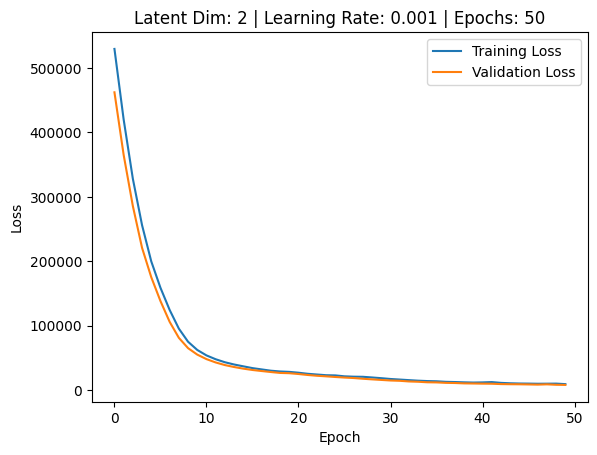

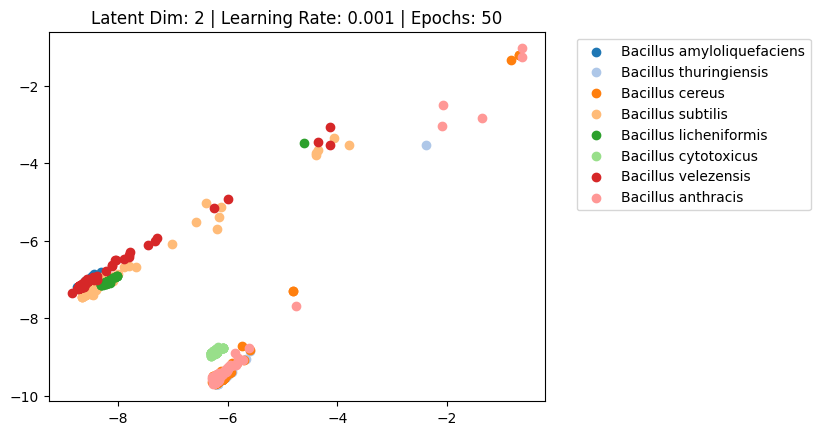

In [7]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index]

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_length, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_length = input_length
        
        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )

        self.fc_mu = nn.Linear(8 * input_length // 4, latent_dim)
        self.fc_var = nn.Linear(8 * input_length // 4, latent_dim)

        # Decoding layers
        self.fc_dec = nn.Linear(latent_dim, 8 * input_length // 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(16, 6, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(x.size(0), 8, -1)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var



def vae_loss(x, x_recon, mu, log_var):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD
    
def train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        model.train()
        for batch_idx, data in enumerate(train_dataloader):
            # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
            data = data.permute(0, 2, 1)
            data = data.float().to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            x_recon, mu, log_var = model(data)

            # Compute the loss
            loss = vae_loss(data, x_recon, mu, log_var)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the training loss
            train_loss += loss.item() * data.size(0)

        # Print the average training loss for the epoch
        train_loss /= len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_dataloader):
              # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
              data = data.permute(0, 2, 1)
              data = data.float().to(device)

              # Forward pass
              x_recon, mu, log_var = model(data)

              # Compute the loss
              loss = vae_loss(data, x_recon, mu, log_var)

              # Update the validation loss
              val_loss += loss.item() * data.size(0)

        val_loss /= len(val_dataloader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
        
        # Append the training loss to the list
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_space_dim, hyperparameters):
    # Set the model to evaluation mode
    model.eval()

    # Create a list to store the latent vectors
    latent_vectors = []
    labels = []

    # Iterate over the sequences in the dataset and obtain their latent vectors
    for sequence, label in zip(flatted_sequence, sequence_labels):
        # Transform the sequence tensor to have the shape (1, n_channels, sequence_length)
        sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
        sequence = sequence.float().to(device)

        # Obtain the latent vector (mu)
        mu, _ = model.encode(sequence)
        mu = mu.detach().cpu().numpy()

        # Add the latent vector to the list
        latent_vectors.append(mu)
        labels.append(label)

    # Convert the list of latent vectors to a 2D numpy array
    latent_vectors_array = np.array(latent_vectors).squeeze()

    if latent_space_dim > 2:
        umap_model = umap.UMAP(n_neighbors=100, min_dist=0.1, random_state=42)
        coords = umap_model.fit_transform(latent_vectors_array)
    else:
        coords = latent_vectors_array

    # Create a scatter plot for each unique label
    unique_labels = set(labels)
    color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

    fig, ax = plt.subplots()
    for label in unique_labels:
        # Get the indices of the data points with this label
        indices = [i for i, x in enumerate(labels) if x == label]

        # Get the corresponding latent vectors or UMAP coordinates and colors
        coords_subset = coords[indices]
        color = color_dict[label]

        # Add the scatter plot for this label to the axes
        ax.scatter(coords_subset[:, 0], coords_subset[:, 1], color=color, label=label)

    # Add the legend to the axes
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_title(f"Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")

    # Save the plot in the 'plots' subdirectory
    os.makedirs(os.path.join(os.getcwd(), "plots"), exist_ok=True)
    filename = f"latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "plots", filename), bbox_inches="tight")

    # Show the plot
    plt.show()

def plot_loss(train_losses, val_losses, hyperparameters):
    plt.figure()
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")
    plt.legend()
    os.makedirs(os.path.join(os.getcwd(), "plots"), exist_ok=True)
    filename = f"loss_latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "plots", filename), bbox_inches="tight")
    plt.show()



def main(alignment_length, latent_dim, learning_rate, n_epochs): #, architecture_name):
    # Instantiate the model with the chosen architecture
    model = VariationalAutoencoder(input_length=alignment_length, latent_dim=latent_dim) #, architecture=architectures[architecture_name])
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the dataloader
    dataset = SequenceDataset(flatted_sequence)
    
    # Split the dataset into training and validation sets
    train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=42)
    
    train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)

    # Train the model
    train_losses, val_losses = train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs)

    # Define the hyperparameters dictionary
    hyperparameters = {
        'latent_dim': latent_dim,
        'learning_rate': learning_rate,
        'n_epochs': n_epochs
    }

    plot_loss(train_losses, val_losses, hyperparameters)
    
    # Plot the latent space
    plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_dim, hyperparameters)


if __name__ == '__main__':

    print(f"alignment length is {alignment_length}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_epochs = 50

    latent_dims = [2]
    learning_rates = [0.001]

    for latent_dim in latent_dims:
        for learning_rate in learning_rates:
              main(alignment_length, latent_dim, learning_rate, n_epochs)


## VAE with a more complex VAE model

Epoch: 1 	Training Loss: 99564.248374 	Validation Loss: 42095.711168
Epoch: 2 	Training Loss: 13877.052438 	Validation Loss: 7339.228447
Epoch: 3 	Training Loss: 6339.594994 	Validation Loss: 5218.600475
Epoch: 4 	Training Loss: 4174.704373 	Validation Loss: 3655.665601
Epoch: 5 	Training Loss: 3351.754681 	Validation Loss: 3357.216931
Epoch: 6 	Training Loss: 2945.905299 	Validation Loss: 2895.176186
Epoch: 7 	Training Loss: 2645.944134 	Validation Loss: 2771.993182
Epoch: 8 	Training Loss: 2504.852973 	Validation Loss: 2601.910642
Epoch: 9 	Training Loss: 2366.200358 	Validation Loss: 2518.027347
Epoch: 10 	Training Loss: 2239.701139 	Validation Loss: 2405.451842
Epoch: 11 	Training Loss: 2119.238776 	Validation Loss: 2671.590442
Epoch: 12 	Training Loss: 2038.914535 	Validation Loss: 2150.208908
Epoch: 13 	Training Loss: 1894.367260 	Validation Loss: 2241.768074
Epoch: 14 	Training Loss: 1877.959733 	Validation Loss: 2159.197620
Epoch: 15 	Training Loss: 1820.999521 	Validation Loss

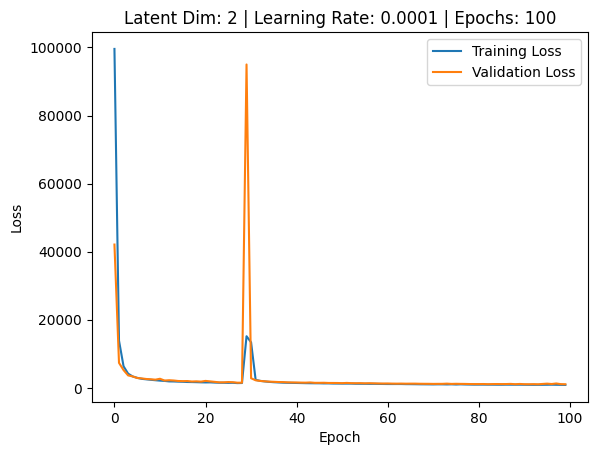

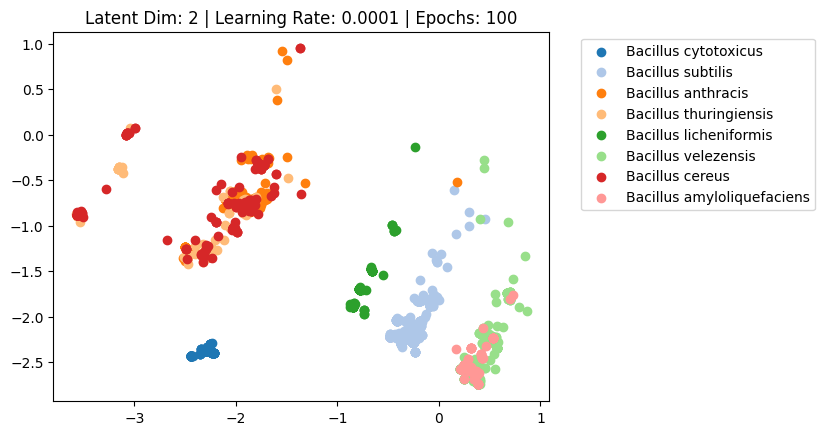

Epoch: 1 	Training Loss: 121315.490268 	Validation Loss: 85187.340616
Epoch: 2 	Training Loss: 33290.315872 	Validation Loss: 9575.995975
Epoch: 3 	Training Loss: 7292.389372 	Validation Loss: 5688.773181
Epoch: 4 	Training Loss: 4881.282472 	Validation Loss: 4547.088950
Epoch: 5 	Training Loss: 4051.859875 	Validation Loss: 3903.102042
Epoch: 6 	Training Loss: 3548.721698 	Validation Loss: 3474.198392
Epoch: 7 	Training Loss: 3202.454068 	Validation Loss: 3276.311486
Epoch: 8 	Training Loss: 2917.359446 	Validation Loss: 2972.679584
Epoch: 9 	Training Loss: 2765.549057 	Validation Loss: 2719.807358
Epoch: 10 	Training Loss: 2515.069220 	Validation Loss: 2640.705604
Epoch: 11 	Training Loss: 2396.436217 	Validation Loss: 2488.511454
Epoch: 12 	Training Loss: 2213.330684 	Validation Loss: 2411.514483
Epoch: 13 	Training Loss: 2105.617459 	Validation Loss: 2379.664065
Epoch: 14 	Training Loss: 2018.766653 	Validation Loss: 2284.253109
Epoch: 15 	Training Loss: 1922.405818 	Validation Los

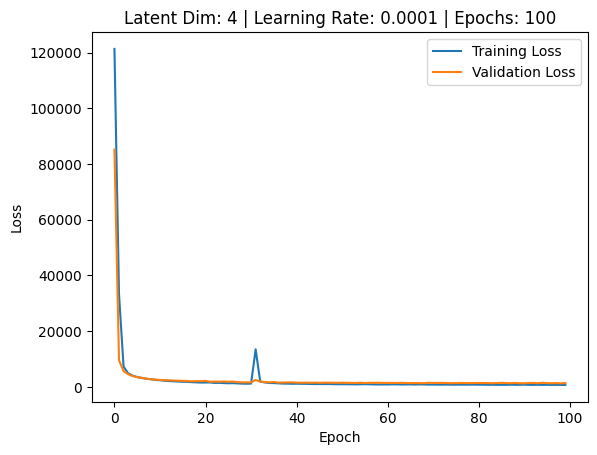

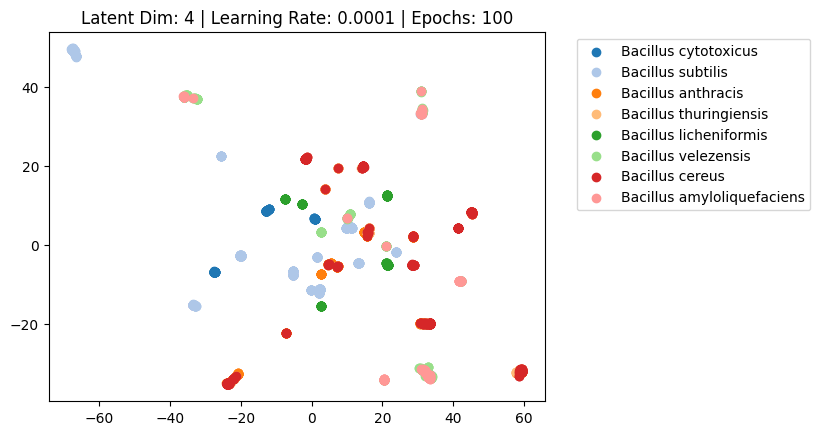

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index]

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_length, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_length = input_length

        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )

        self.encoder_output_dim = 256 * 93
        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_var = nn.Linear(self.encoder_output_dim, latent_dim)

        # Decoding layers
        self.decoder_input_dim = self.encoder_output_dim
        self.fc_dec = nn.Linear(latent_dim, self.decoder_input_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 32, kernel_size=753, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 6, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )


        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(x.size(0), 256, -1)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var




def vae_loss(x, x_recon, mu, log_var):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD
    
def train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        model.train()
        for batch_idx, data in enumerate(train_dataloader):
            # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
            data = data.permute(0, 2, 1)
            data = data.float().to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            x_recon, mu, log_var = model(data)

            # Compute the loss
            loss = vae_loss(data, x_recon, mu, log_var)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the training loss
            train_loss += loss.item() * data.size(0)

        # Print the average training loss for the epoch
        train_loss /= len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_dataloader):
              # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
              data = data.permute(0, 2, 1)
              data = data.float().to(device)

              # Forward pass
              x_recon, mu, log_var = model(data)

              # Compute the loss
              loss = vae_loss(data, x_recon, mu, log_var)

              # Update the validation loss
              val_loss += loss.item() * data.size(0)

        val_loss /= len(val_dataloader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
        
        # Append the training loss to the list
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_space_dim, hyperparameters):
    # Set the model to evaluation mode
    model.eval()

    # Create a list to store the latent vectors
    latent_vectors = []
    labels = []

    # Iterate over the sequences in the dataset and obtain their latent vectors
    for sequence, label in zip(flatted_sequence, sequence_labels):
        # Transform the sequence tensor to have the shape (1, n_channels, sequence_length)
        sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
        sequence = sequence.float().to(device)

        # Obtain the latent vector (mu)
        mu, _ = model.encode(sequence)
        mu = mu.detach().cpu().numpy()

        # Add the latent vector to the list
        latent_vectors.append(mu)
        labels.append(label)

    # Convert the list of latent vectors to a 2D numpy array
    latent_vectors_array = np.array(latent_vectors).squeeze()

    if latent_space_dim > 2:
        umap_model = umap.UMAP(n_neighbors=100, min_dist=0.1, random_state=42)
        coords = umap_model.fit_transform(latent_vectors_array)
    else:
        coords = latent_vectors_array

    # Create a scatter plot for each unique label
    unique_labels = set(labels)
    color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

    fig, ax = plt.subplots()
    for label in unique_labels:
        # Get the indices of the data points with this label
        indices = [i for i, x in enumerate(labels) if x == label]

        # Get the corresponding latent vectors or UMAP coordinates and colors
        coords_subset = coords[indices]
        color = color_dict[label]

        # Add the scatter plot for this label to the axes
        ax.scatter(coords_subset[:, 0], coords_subset[:, 1], color=color, label=label)

    # Add the legend to the axes
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_title(f"Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")

    # Save the plot in the 'plots' subdirectory
    os.makedirs(os.path.join(os.getcwd(), "plots"), exist_ok=True)
    filename = f"latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "plots", filename), bbox_inches="tight")

    # Show the plot
    plt.show()

def plot_loss(train_losses, val_losses, hyperparameters):
    plt.figure()
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")
    plt.legend()
    os.makedirs(os.path.join(os.getcwd(), "plots"), exist_ok=True)
    filename = f"loss_latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "plots", filename), bbox_inches="tight")
    plt.show()



def main(alignment_length, latent_dim, learning_rate, n_epochs): #, architecture_name):
    # Instantiate the model with the chosen architecture
    model = VariationalAutoencoder(input_length=alignment_length, latent_dim=latent_dim) #, architecture=architectures[architecture_name])
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the dataloader
    dataset = SequenceDataset(flatted_sequence)
    
    # Split the dataset into training and validation sets
    train_set, val_set = train_test_split(dataset, test_size=0.2)
    
    train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)

    # Train the model
    train_losses, val_losses = train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs)

    # Define the hyperparameters dictionary
    hyperparameters = {
        'latent_dim': latent_dim,
        'learning_rate': learning_rate,
        'n_epochs': n_epochs
    }

    plot_loss(train_losses, val_losses, hyperparameters)
    
    # Plot the latent space
    plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_dim, hyperparameters)


if __name__ == '__main__':

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    alignment_length = 1500
    n_epochs = 100

    latent_dims = [2, 4]
    learning_rates = [0.0001]

    for latent_dim in latent_dims:
        for learning_rate in learning_rates:
              main(alignment_length, latent_dim, learning_rate, n_epochs)


Epoch: 1 	Training Loss: 113386.366198 	Validation Loss: 56236.574494
Epoch: 2 	Training Loss: 19164.078030 	Validation Loss: 9056.632144
Epoch: 3 	Training Loss: 8051.065911 	Validation Loss: 6288.410108
Epoch: 4 	Training Loss: 5523.569574 	Validation Loss: 4579.167293
Epoch: 5 	Training Loss: 4315.198076 	Validation Loss: 3822.421420
Epoch: 6 	Training Loss: 3779.455824 	Validation Loss: 3428.536948
Epoch: 7 	Training Loss: 3433.778261 	Validation Loss: 3080.970441
Epoch: 8 	Training Loss: 3154.729626 	Validation Loss: 2951.269767
Epoch: 9 	Training Loss: 2914.162946 	Validation Loss: 2626.768750
Epoch: 10 	Training Loss: 2794.729387 	Validation Loss: 2558.801619


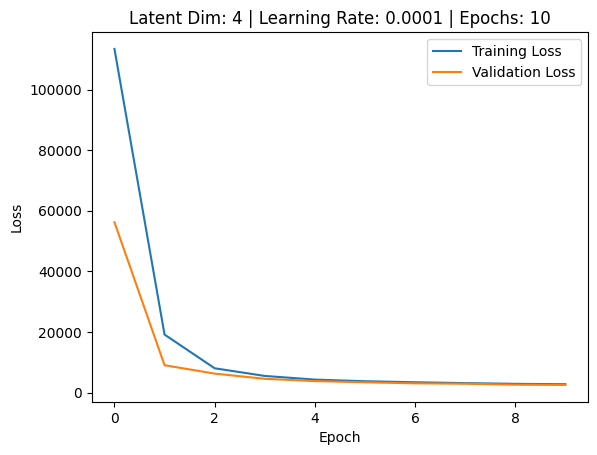

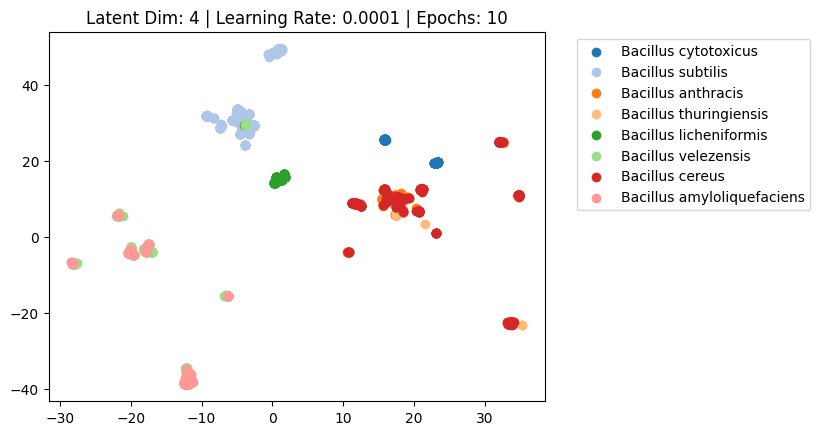

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index]

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_length, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_length = input_length

        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )

        self.encoder_output_dim = 256 * 93
        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_var = nn.Linear(self.encoder_output_dim, latent_dim)

        # Decoding layers
        self.decoder_input_dim = self.encoder_output_dim
        self.fc_dec = nn.Linear(latent_dim, self.decoder_input_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 32, kernel_size=753, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 6, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )


        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(x.size(0), 256, -1)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var




def vae_loss(x, x_recon, mu, log_var):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD
    
def train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        model.train()
        for batch_idx, data in enumerate(train_dataloader):
            # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
            data = data.permute(0, 2, 1)
            data = data.float().to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            x_recon, mu, log_var = model(data)

            # Compute the loss
            loss = vae_loss(data, x_recon, mu, log_var)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the training loss
            train_loss += loss.item() * data.size(0)

        # Print the average training loss for the epoch
        train_loss /= len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_dataloader):
              # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
              data = data.permute(0, 2, 1)
              data = data.float().to(device)

              # Forward pass
              x_recon, mu, log_var = model(data)

              # Compute the loss
              loss = vae_loss(data, x_recon, mu, log_var)

              # Update the validation loss
              val_loss += loss.item() * data.size(0)

        val_loss /= len(val_dataloader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
        
        # Append the training loss to the list
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_space_dim, hyperparameters):
    # Set the model to evaluation mode
    model.eval()

    # Create a list to store the latent vectors
    latent_vectors = []
    labels = []

    # Iterate over the sequences in the dataset and obtain their latent vectors
    for sequence, label in zip(flatted_sequence, sequence_labels):
        # Transform the sequence tensor to have the shape (1, n_channels, sequence_length)
        sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
        sequence = sequence.float().to(device)

        # Obtain the latent vector (mu)
        mu, _ = model.encode(sequence)
        mu = mu.detach().cpu().numpy()

        # Add the latent vector to the list
        latent_vectors.append(mu)
        labels.append(label)

    # Convert the list of latent vectors to a 2D numpy array
    latent_vectors_array = np.array(latent_vectors).squeeze()

    if latent_space_dim > 2:
        umap_model = umap.UMAP(n_neighbors = 1000)
        coords = umap_model.fit_transform(latent_vectors_array)
    else:
        coords = latent_vectors_array

    # Create a scatter plot for each unique label
    unique_labels = set(labels)
    color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

    fig, ax = plt.subplots()
    for label in unique_labels:
        # Get the indices of the data points with this label
        indices = [i for i, x in enumerate(labels) if x == label]

        # Get the corresponding latent vectors or UMAP coordinates and colors
        coords_subset = coords[indices]
        color = color_dict[label]

        # Add the scatter plot for this label to the axes
        ax.scatter(coords_subset[:, 0], coords_subset[:, 1], color=color, label=label)

    # Add the legend to the axes
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_title(f"Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")

    # Save the plot in the 'plots' subdirectory
    os.makedirs(os.path.join(os.getcwd(), "plots"), exist_ok=True)
    filename = f"latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "plots", filename), bbox_inches="tight")

    # Show the plot
    plt.show()

def plot_loss(train_losses, val_losses, hyperparameters):
    plt.figure()
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")
    plt.legend()
    os.makedirs(os.path.join(os.getcwd(), "plots"), exist_ok=True)
    filename = f"loss_latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "plots", filename), bbox_inches="tight")
    plt.show()



def main(alignment_length, latent_dim, learning_rate, n_epochs): #, architecture_name):
    # Instantiate the model with the chosen architecture
    model = VariationalAutoencoder(input_length=alignment_length, latent_dim=latent_dim) #, architecture=architectures[architecture_name])
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the dataloader
    dataset = SequenceDataset(flatted_sequence)
    
    # Split the dataset into training and validation sets
    train_set, val_set = train_test_split(dataset, test_size=0.2)
    
    train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)

    # Train the model
    train_losses, val_losses = train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs)

    # Define the hyperparameters dictionary
    hyperparameters = {
        'latent_dim': latent_dim,
        'learning_rate': learning_rate,
        'n_epochs': n_epochs
    }

    plot_loss(train_losses, val_losses, hyperparameters)
    
    # Plot the latent space
    plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_dim, hyperparameters)


if __name__ == '__main__':

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    alignment_length = 1500
    n_epochs = 10

    latent_dims = [4]
    learning_rates = [0.0001]

    for latent_dim in latent_dims:
        for learning_rate in learning_rates:
              main(alignment_length, latent_dim, learning_rate, n_epochs)


In [ ]:
    var = nn.ConvTranspose1d(32, 6, kernel_size=6, stride=2, padding=1, output_padding=1),  # Changed kernel_size from 5 to 6
    print(var.shape)

AttributeError: ignored

In [ ]:
print(type(flatted_sequence))
print(flatted_sequence[0:3])
print(type(sequence_labels))
print(sequence_labels[0:3])

<class 'list'>
[array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])]
<class 'list'>
['Bacillus amyloliquefaciens', 'Bacillus amyloliquefaciens', 'Bacillus amyloliquefaciens']


## Convolutional Classifier



In [ ]:
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Define the model

class ConvClassifier(nn.Module):
    def __init__(self, input_length, num_classes):
        super(ConvClassifier, self).__init__()
        self.input_length = input_length
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
        )

        # Calculate the size of the final feature map after convolutional and pooling layers
        feature_map_size = input_length // (2 * 2 * 2)

        # Define the classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(64 * feature_map_size, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Change dataset to include labels

class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __getitem__(self, index):
        return {
            "sequence": torch.tensor(self.sequences[index]).float(),
            "label": torch.tensor(self.labels[index]).long(),
        }

    def __len__(self):
        return len(self.sequences)

## Encode labels into integers

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(sequence_labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(flatted_sequence, encoded_labels, test_size=0.2, random_state=42)


# Create separate datasets and dataloaders for training and test sets
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(np.unique(encoded_labels))
model = ConvClassifier(input_length=alignment_length, num_classes=num_classes)
model.to(device)
print(model)



ConvClassifier(
  (features): Sequential(
    (0): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU(inplace=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=11968, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=8, bias=True)
  )
)


Epoch: 1 	Training Loss: 1.790186 	Test Loss: 1.259301
Epoch: 2 	Training Loss: 0.962142 	Test Loss: 0.669744
Epoch: 3 	Training Loss: 0.670087 	Test Loss: 0.665295
Epoch: 4 	Training Loss: 0.655298 	Test Loss: 0.637329
Epoch: 5 	Training Loss: 0.626306 	Test Loss: 0.613292
Epoch: 6 	Training Loss: 0.617155 	Test Loss: 0.615736
Epoch: 7 	Training Loss: 0.598827 	Test Loss: 0.608979
Epoch: 8 	Training Loss: 0.586045 	Test Loss: 0.570781
Epoch: 9 	Training Loss: 0.573674 	Test Loss: 0.559775
Epoch: 10 	Training Loss: 0.565486 	Test Loss: 0.554676
Epoch: 11 	Training Loss: 0.552928 	Test Loss: 0.585004
Epoch: 12 	Training Loss: 0.552370 	Test Loss: 0.531960
Epoch: 13 	Training Loss: 0.535110 	Test Loss: 0.537495
Epoch: 14 	Training Loss: 0.528043 	Test Loss: 0.515234
Epoch: 15 	Training Loss: 0.526174 	Test Loss: 0.518314
Epoch: 16 	Training Loss: 0.517118 	Test Loss: 0.527777
Epoch: 17 	Training Loss: 0.517945 	Test Loss: 0.521334
Epoch: 18 	Training Loss: 0.515107 	Test Loss: 0.511096
E

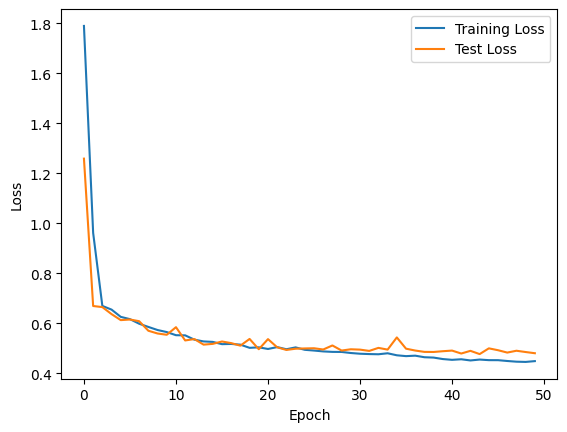

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(flatted_sequence, encoded_labels, test_size=0.2, random_state=42)

# Create separate datasets and dataloaders for training and test sets
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(np.unique(encoded_labels))
model = ConvClassifier(input_length=alignment_length, num_classes=num_classes)
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50

train_losses = []
test_losses = []

for epoch in range(1, n_epochs+1):
    # Training loop
    train_loss = 0.0
    model.train()
    for batch in train_dataloader:
        sequence_data = batch["sequence"].permute(0, 2, 1).float().to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(sequence_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * sequence_data.size(0)

    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Test loop
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            sequence_data = batch["sequence"].permute(0, 2, 1).float().to(device)
            labels = batch["label"].to(device)

            outputs = model(sequence_data)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * sequence_data.size(0)

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tTest Loss: {test_loss:.6f}")

# Plot the training and test errors
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions for the test set
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        sequence_data = batch["sequence"].permute(0, 2, 1).float().to(device)
        labels = batch["label"].to(device)

        outputs = model(sequence_data)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_

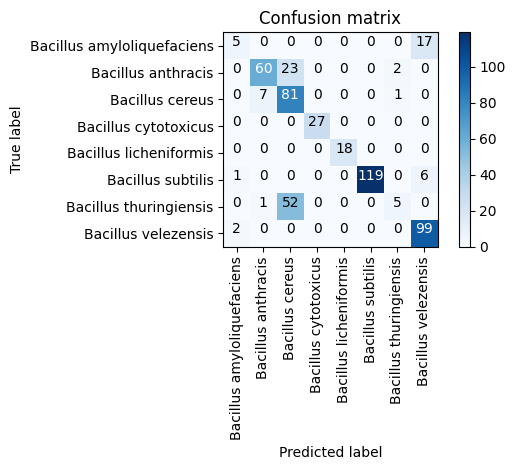

In [ ]:


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names)
plt.show()
